# Richter's Predictor: Modeling Earthquake Damage
_Hosted By DrivenData_

The dataset mainly consists of information on the buildings' structure and their legal ownership. Each row in the dataset represents a specific building in the region that was hit by the Gorkha earthquake.

We're trying to predict the ordinal variable `damage_grade`, which represents a level of damage to the building that was hit by the earthquake. There are 3 grades of the damage:

 1. represents low damage
 2. represents a medium amount of damage
 3. represents almost complete destruction

The level of damage is an ordinal variable meaning that ordering is important. This can be viewed as a classification or an ordinal regression problem. 
 
To measure the performance of our algorithms, we'll use the _F1 score_ which balances the precision and recall of a classifier. Traditionally, the F1 score is used to evaluate performance on a binary classifier, but since we have three possible labels we will use a variant called the _micro averaged F1 score_.
 
 - [Loading data](#Loading-data)
 - [Exploratory data analysis](#Exploratory-data-analysis)
 - [Model training](#Model-training)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Loading data

In [3]:
project_root_dir = '/Users/angelo/Programming/data/modeling-earthquake-damage'
train_values_file = os.path.join(project_root_dir, 'train_values.csv')
train_labels_file = os.path.join(project_root_dir, 'train_labels.csv')
test_values_file = os.path.join(project_root_dir, 'test_values.csv')

In [4]:
train_values_df = pd.read_csv(train_values_file)
train_labels_df = pd.read_csv(train_labels_file)
test_values_df = pd.read_csv(test_values_file)

In [5]:
has_df_columns = train_values_df.filter(regex='has_').columns
train_values_df[has_df_columns] = train_values_df[has_df_columns].astype('object')

In [6]:
train_values_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [7]:
col_int = train_values_df.select_dtypes('int64').columns
col_cat = train_values_df.select_dtypes('object').columns

In [8]:
train_values_df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [9]:
train_labels_df.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [10]:
test_values_df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [11]:
train_values_df.nunique().sort_values(ascending=False)

building_id                               260601
geo_level_3_id                             11595
geo_level_2_id                              1414
area_percentage                               84
age                                           42
geo_level_1_id                                31
height_percentage                             27
count_families                                10
plan_configuration                            10
count_floors_pre_eq                            9
ground_floor_type                              5
foundation_type                                5
legal_ownership_status                         4
other_floor_type                               4
position                                       4
roof_type                                      3
land_surface_condition                         3
has_superstructure_stone_flag                  2
has_superstructure_adobe_mud                   2
has_superstructure_mud_mortar_stone            2
has_secondary_use_ot

In [12]:
train_values_df.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

In [13]:
train_values_df.describe().applymap('{:.2f}'.format)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
count,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00
mean,525675.48,13.90,701.07,6257.88,2.13,26.54,8.02,5.43,0.98
std,304545.00,8.03,412.71,3646.37,0.73,73.57,4.39,1.92,0.42
min,4.00,0.00,0.00,0.00,1.00,0.00,1.00,2.00,0.00
25%,261190.00,7.00,350.00,3073.00,2.00,10.00,5.00,4.00,1.00
50%,525757.00,12.00,702.00,6270.00,2.00,15.00,7.00,5.00,1.00
75%,789762.00,21.00,1050.00,9412.00,2.00,30.00,9.00,6.00,1.00
max,1052934.00,30.00,1427.00,12567.00,9.00,995.00,100.00,32.00,9.00


## Exploratory data analysis

In [14]:
print(f'Integer-value columns: {list(col_int)}')

Integer-value columns: ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']


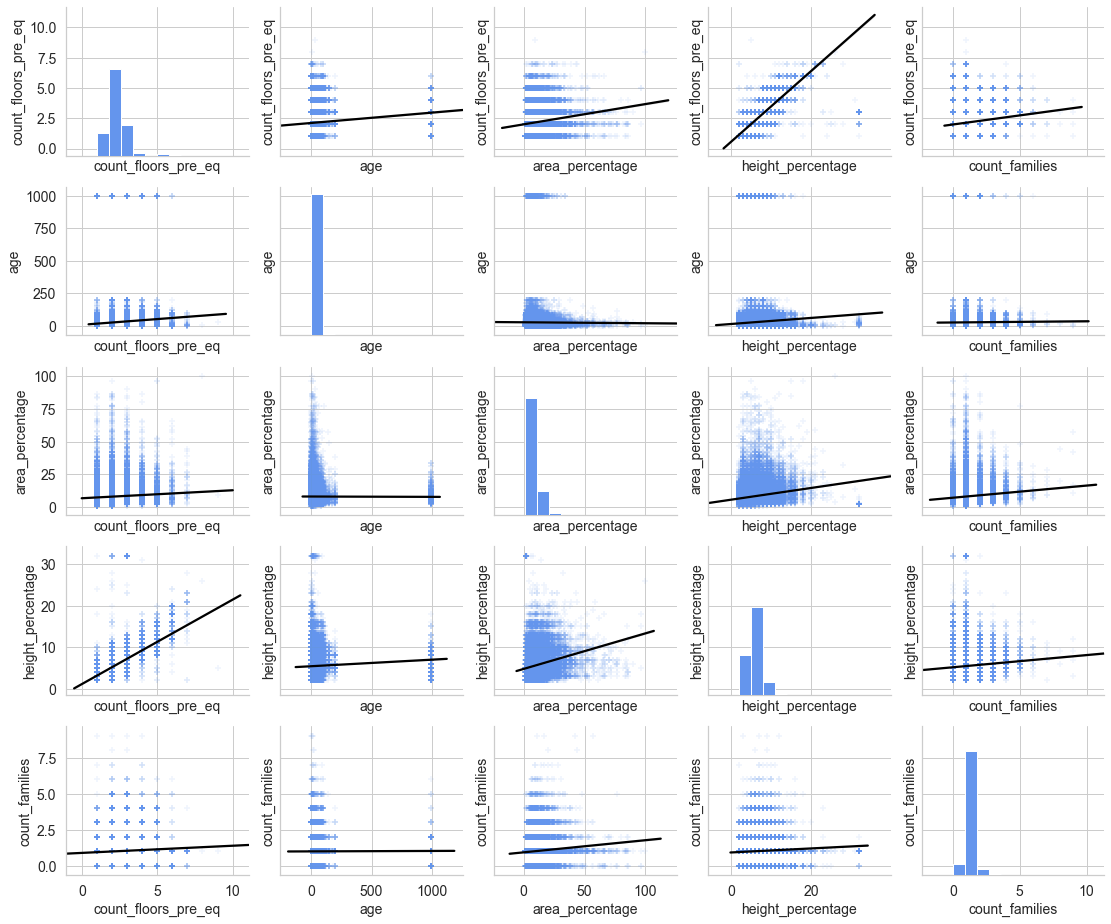

In [15]:
sns.set(style='whitegrid', color_codes=True)
color_ref = 'cornflowerblue'
g = sns.pairplot(train_values_df, x_vars=col_int[4:9], y_vars=col_int[4:9], height=2.6, aspect=1.2, kind='reg', diag_kind='hist', \
                 markers='+', diag_kws={'color': color_ref}, plot_kws={'line_kws': {'color': 'black'}, 'scatter_kws': {'alpha': 0.1, 'color': color_ref}})
xlabels, ylabels = [], []
label_font_size = 14

for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        g.axes[j, i].xaxis.set_label_text(xlabels[i])
        g.axes[j, i].xaxis.label.set_size(label_font_size)
        g.axes[j, i].tick_params(axis='x', which='major', labelsize=label_font_size)
        g.axes[j, i].yaxis.set_label_text(ylabels[j])
        g.axes[j, i].yaxis.label.set_size(label_font_size)
        g.axes[j, i].tick_params(axis='y', which='major', labelsize=label_font_size)

plt.tight_layout();

In [16]:
print(f'Categorical-value columns: {list(col_cat)}\n')
print(f'Number of categorical columns: {len(col_cat)}\n')
list_tuple_has_df_columns = [(has_df_columns[i], has_df_columns[j]) for i, j in zip(range(0, len(has_df_columns)-1, 2), range(1, len(has_df_columns), 2))]
print(f'List of tuples: {list_tuple_has_df_columns}\n')
print(f'Number of tuples: {len(list_tuple_has_df_columns)}\n')
list_remainders = list(set(col_cat) - set(has_df_columns))
print(f'Remainder columns: {list(list_remainders)}\n')
print(f'Number of reminder columns: {len(list_remainders)}\n')
list_tuple_remainders = [(list_remainders[i], list_remainders[j]) for i, j in zip(range(0, len(list_remainders)-1, 2), range(1, len(list_remainders), 2))]
print(f'List tuple remainders: {list_tuple_remainders}')

Categorical-value columns: ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']

Number of categorical columns: 30

List of tuples: [('has_superstructure_adobe_mud', 'has_superstru

In [17]:
def bar_plot(ax, df, col):
    for i in range(0, 2):
        df_col = df[col[i]].value_counts(ascending=False)
        df_col = df_col/df_col.sum()*100
        df_col = df_col.reset_index().rename(columns={'index': 'features'})
        ax[i].bar(df_col['features'], df_col[col[i]], color=colors, edgecolor='k')        
        if all(isinstance(tick, np.float64) for tick in ax[i].get_xticks()):
            ax[i].set_xticks(range(0, 2))
            ax[i].set_xticklabels(['No', 'Yes'])
        plt.setp(ax[i].get_xticklabels(), ha="right", rotation_mode="anchor", rotation=0, fontsize=14)
        plt.setp(ax[i].get_yticklabels(), fontsize=12)
        ax[i].set_ylabel('Percent (%)', fontsize=14)
        ax[i].set_title(col[i], fontsize=14)
        plt.grid(True, linestyle=':');

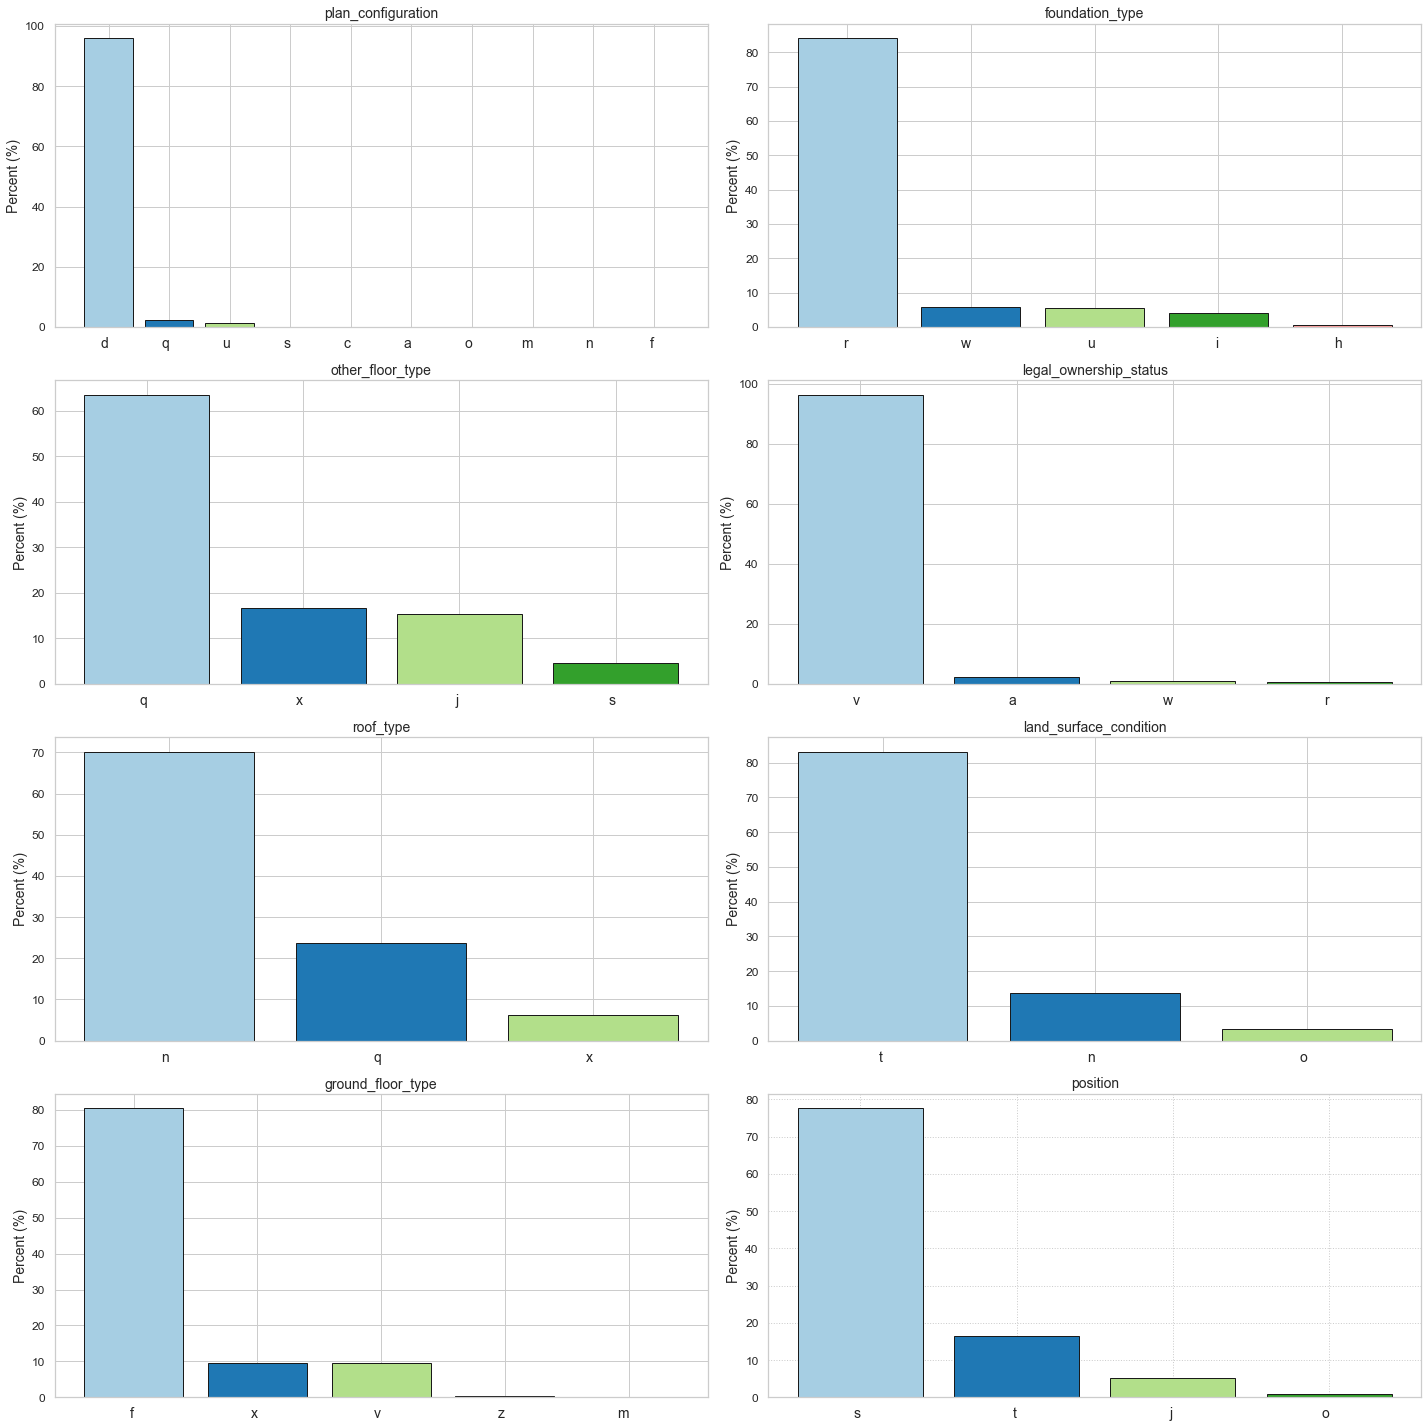

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
colors = plt.cm.Paired.colors
for ax, col in zip(axes, list_tuple_remainders):
    bar_plot(ax, train_values_df, col)
fig.tight_layout()

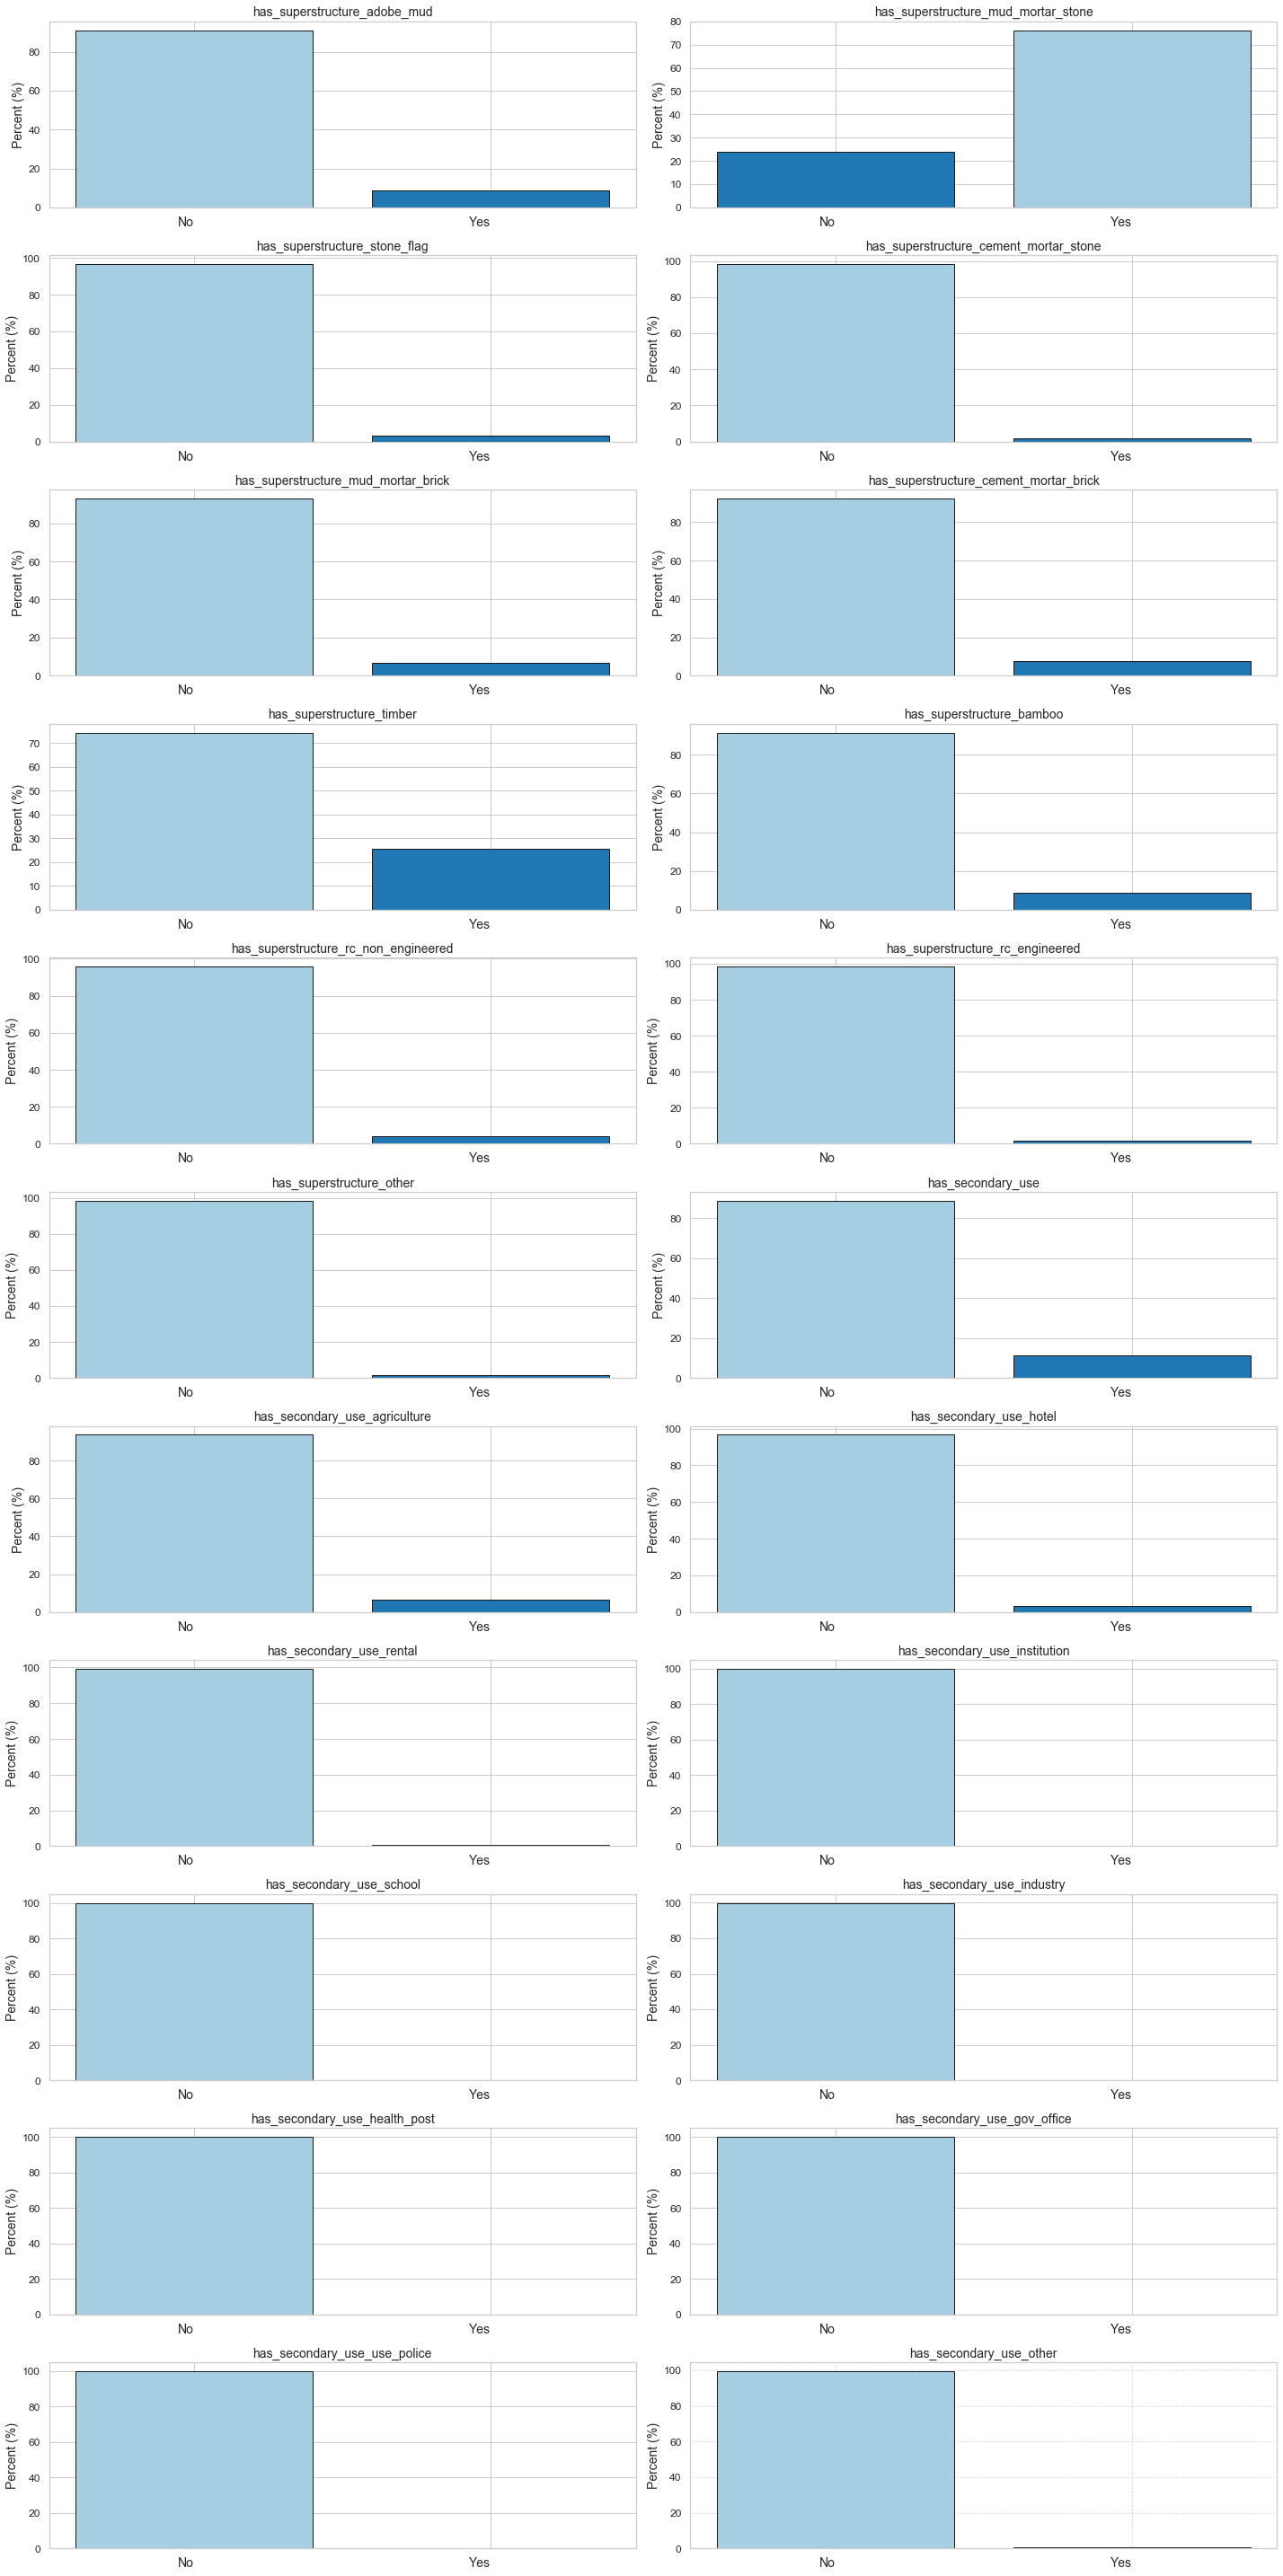

In [19]:
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(20, 40))
colors = plt.cm.Paired.colors
for ax, col in zip(axes, list_tuple_has_df_columns):
    bar_plot(ax, train_values_df, col)
fig.tight_layout()

## Model training

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [21]:
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(), col_cat)])
train_values_cat_df = train_values_df.select_dtypes('object')

In [22]:
train_values_cat_prepared_df = full_pipeline.fit_transform(train_values_cat_df)